# Data Project

### Using University data to predict carbon emmissions outputs, based on staff numbers and students, to predict appropriate carbon emmissions targets. We will then also review, if regional factors affect carbon emmissions.

## Section 1: Preparing the data

#### First, we need to import our libraries, and wrangle the data into a format that is appropriate for our aims.

In [1]:
#importing required libraries

import pandas as pd
from pandas.io.json import json_normalize
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import requests
import geopy
from geopy.geocoders import Nominatim
import folium

In [2]:
#Loading data
student_data = pd.read_csv('student_data.csv')
staff_data = pd.read_csv('staff_data.csv')
emr_data = pd.read_csv('emr_data.csv')
location_data = pd.read_csv('provider data.csv')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We only want to use data from the academic year 2018/19, and we only want to estimate scope 1 and 2 carbon emissions (which are those caused directly by University operations), so we need to filter out the other data.

In [3]:
#Filtering the data sets
stu_filtered = student_data['Academic year']=='2018/19'
df1 = pd.DataFrame(student_data[stu_filtered])

sta_filtered = staff_data['Academic Year']=='2018/19'
df2 = pd.DataFrame(staff_data[sta_filtered])

EMR1_filtered = emr_data['Academic Year']=='2018/19'
EMR2_filtered = emr_data[EMR1_filtered]
EMR3_filtered = EMR2_filtered['Category']=='Total gross internal area (m2)'
df3 = pd.DataFrame(EMR2_filtered[EMR3_filtered])

EMR4_filtered = emr_data['Academic Year']=='2018/19'
EMR5_filtered = emr_data[EMR4_filtered]
EMR6_filtered = EMR5_filtered['Category']=='Total scope 1 and 2 carbon emissions (Kg CO2e)'
df4 = pd.DataFrame(EMR5_filtered[EMR6_filtered])

We want our final data to show student number, staff number, GIA, and carbon emmissions per institution, so we need to group by UKPRN (the unique provider number) and then merge the data.

In [4]:
#grouping the data by provider
df1 = df1.groupby(by='UKPRN').sum()
df2 = df2.groupby(by='UKPRN').sum()
df3 = df3.groupby(by='UKPRN').sum()
df4 = df4.groupby(by='UKPRN').sum()

In [5]:
#merging the data into one dataframe
c_df = pd.merge(df1, df2, on ="UKPRN")
c_df2 = pd.merge(df3, df4, on ="UKPRN")

data1 = pd.merge(c_df, c_df2, on ="UKPRN")
data = pd.merge(data1, location_data, on ="UKPRN")


In [6]:
#cleaning the dataframe and renaming columns
data = data[['UKPRN', 'HE Provider_x', 'Number_x', 'Number_y', 'Value_x', 'Value_y', 'LONGITUDE', 'LATITUDE']]
s_data = data.rename(columns={'HE Provider_x':'Provider', 'Number_x':'Student_Number', 'Number_y':'Staff_Number', 'Value_x':'GIA', 'Value_y':'Carbon_Emissions_Kg_CO2e', 'LATITUDE':'Latitude', 'LONGITUDE':'Longitude'})
c_data = s_data.dropna()


Here is our data:

In [7]:
c_data[["GIA", "Carbon_Emissions_Kg_CO2e"]] = c_data[["GIA", "Carbon_Emissions_Kg_CO2e"]].apply(pd.to_numeric)
c_data

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude
0,10000291.0,Anglia Ruskin University,1763180,118000,129750.17,6005516.418,0.474311,51.741266
1,10000385.0,The Arts University Bournemouth,243940,22720,35090.95,1133069.664,-1.897700,50.741781
2,10000571.0,Bath Spa University,559280,51160,68954.00,2486984.472,-2.437400,51.378739
3,10000712.0,University College Birmingham,353240,27060,67293.81,3102714.214,-1.905934,52.481855
4,10000824.0,Bournemouth University,1287320,75420,91393.00,3581959.766,-1.897159,50.742968
...,...,...,...,...,...,...,...,...
150,10008026.0,St Mary's University College,75260,6240,14585.00,490116.680,-5.961300,54.592000
151,10008640.0,Falmouth University,462420,24120,74766.92,2993218.522,-5.070901,50.149168
152,10014001.0,University of Suffolk,553860,22200,27071.30,1164296.062,1.162554,52.052585
153,10037449.0,University of St Mark and St John,199600,16600,34443.00,1689156.066,-4.110286,50.421023


In [8]:
c_data.dtypes

UKPRN                       float64
Provider                     object
Student_Number                int64
Staff_Number                  int64
GIA                         float64
Carbon_Emissions_Kg_CO2e    float64
Longitude                   float64
Latitude                    float64
dtype: object

We'll add a couple more columns for further testing:

In [9]:
c_data['GIA_per_student'] = c_data['GIA']/(c_data['Student_Number'])
c_data['GIA_per_staff'] = c_data['GIA']/(c_data['Staff_Number'])
c_data

<ipython-input-9-1715a3f07801>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['GIA_per_student'] = c_data['GIA']/(c_data['Student_Number'])
<ipython-input-9-1715a3f07801>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['GIA_per_staff'] = c_data['GIA']/(c_data['Staff_Number'])


,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff
0,10000291.0,Anglia Ruskin University,1763180,118000,129750.17,6005516.418,0.474311,51.741266,0.073589,1.099578
1,10000385.0,The Arts University Bournemouth,243940,22720,35090.95,1133069.664,-1.897700,50.741781,0.143851,1.544496
2,10000571.0,Bath Spa University,559280,51160,68954.00,2486984.472,-2.437400,51.378739,0.123291,1.347811
3,10000712.0,University College Birmingham,353240,27060,67293.81,3102714.214,-1.905934,52.481855,0.190505,2.486837
4,10000824.0,Bournemouth University,1287320,75420,91393.00,3581959.766,-1.897159,50.742968,0.070995,1.211787
...,...,...,...,...,...,...,...,...,...,...
150,10008026.0,St Mary's University College,75260,6240,14585.00,490116.680,-5.961300,54.592000,0.193795,2.337340
151,10008640.0,Falmouth University,462420,24120,74766.92,2993218.522,-5.070901,50.149168,0.161686,3.099789
152,10014001.0,University of Suffolk,553860,22200,27071.30,1164296.062,1.162554,52.052585,0.048878,1.219428
153,10037449.0,University of St Mark and St John,199600,16600,34443.00,1689156.066,-4.110286,50.421023,0.172560,2.074880


Let's visualise some of the key data fields we'll be looking at.

<function matplotlib.pyplot.show(close=None, block=None)>

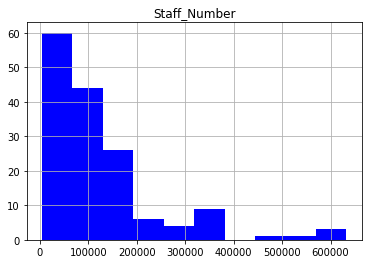

In [10]:
c_data[['Staff_Number']].hist(color = 'blue')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

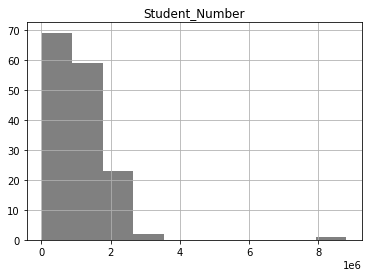

In [11]:
c_data[['Student_Number']].hist(color = 'grey')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

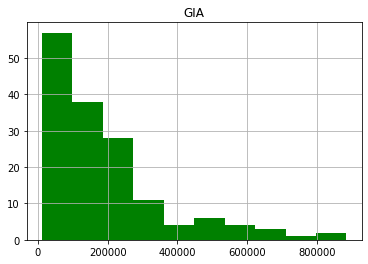

In [12]:
c_data[['GIA']].hist(color = 'green')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

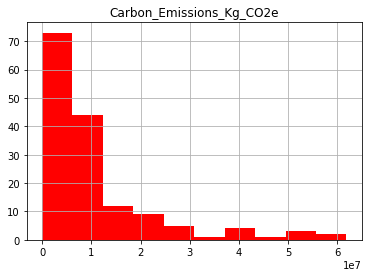

In [13]:
c_data[['Carbon_Emissions_Kg_CO2e']].hist(color = 'red')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

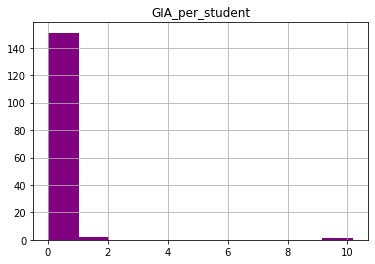

In [14]:
c_data[['GIA_per_student']].hist(color = 'purple')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

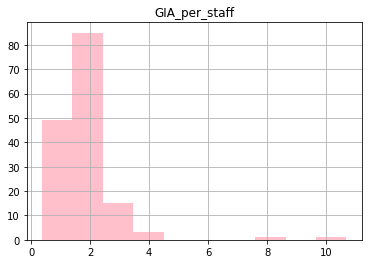

In [15]:
c_data[['GIA_per_staff']].hist(color = 'pink')
plt.show

Now that we have the data, we'll plot all the UK universities on a map

In [16]:
address = 'UK'

geolocator = Nominatim(user_agent="UK")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


print(latitude, longitude)

54.7023545 -3.2765753


In [17]:
#mapping UK

map_UK = folium.Map(location=[latitude, longitude], zoom_start=5)

for latitude, longitude, Provider in zip(c_data['Latitude'], c_data['Longitude'], c_data['Provider']):
    label = '{}'.format(Provider)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=2,
        popup=label,
        color='black',
        fill=False
        ).add_to(map_UK)  
    
map_UK

## Section 2: Testing the correlation between carbon emmissions, staff and student populations, and gross internal area

#### Next we will test some key relationships, to assess how to best predict carbon emmisions based off available data. These will be the relationships between:
   - Student populations and carbon emmissions
   - Staff populations and carbon emmissions
   - Gross internal area and carbon emmisions
   - Carbon emmisions and gross internal area per student
   - Carbon emmisions and gross internal area per staff

We will first model these separately, and then conduct multiple linear regression, to the strength of the correlations.
The tests will follow the structure:
1. plotting the variables on a scatter graph
2. Analysing the linear regression, to get the coefficient and intercept
3. plotting the linear regression on top of the scatter chart
4. analysing the strength of the linear regression

In [18]:
#Split into train and test
msk = np.random.rand(len(c_data)) < 0.8
train = c_data[msk]
test = c_data[~msk]

##### test 1

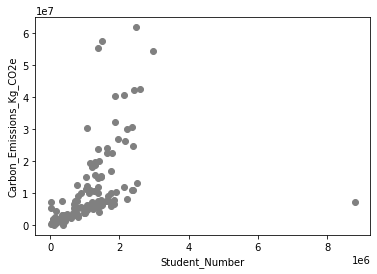

In [19]:
#Train Data distribution
plt.scatter(train.Student_Number, train.Carbon_Emissions_Kg_CO2e, color='Grey')
plt.xlabel("Student_Number")
plt.ylabel("Carbon_Emissions_Kg_CO2e")
plt.show()

In [20]:
#Modelling Data
regr1 = linear_model.LinearRegression()
train_x1 = np.asanyarray(train[['Student_Number']])
train_y1 = np.asanyarray(train[["Carbon_Emissions_Kg_CO2e"]])
regr1.fit (train_x1, train_y1)
print ('Coefficients: ', regr1.coef_)
print ('Intercept: ',regr1.intercept_)

Coefficients:  [[5.98059326]]
Intercept:  [4328458.4420753]


Text(0, 0.5, 'Carbon_Emissions_Kg_CO2e')

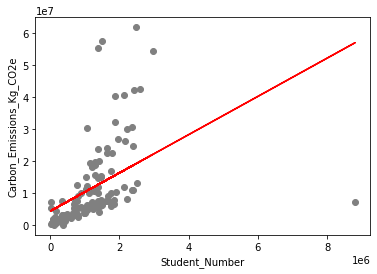

In [21]:
#Plot Outputs
plt.scatter(train.Student_Number, train.Carbon_Emissions_Kg_CO2e, color='Grey')
plt.plot(train_x1, regr1.coef_[0][0]*train_x1 + regr1.intercept_[0], '-r')
plt.xlabel('Student_Number')
plt.ylabel("Carbon_Emissions_Kg_CO2e")

In [22]:
#Evaluation
test_x1 = np.asanyarray(test[['Student_Number']])
test_y1 = np.asanyarray(test[["Carbon_Emissions_Kg_CO2e"]])
test_y_1 = regr1.predict(test_x1)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_1 - test_y1)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_1 - test_y1) ** 2))
print("R2-score: %.2f" % r2_score(test_y1 , test_y_1) )                         

Mean absolute error: 6364298.54
Residual sum of squares (MSE): 88361692470171.06
R2-score: 0.36


We can see that there is no strong correlation between student number and carbon emmissions, though from the graph, this may be because of the outlier in the bottom right. If we were only relying on this variable, we would filter out the outlier to create a more reliable metric.

#### test 2

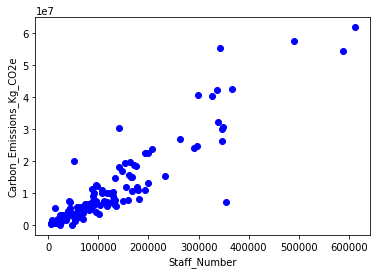

In [23]:
#Train Data distribution
plt.scatter(train.Staff_Number, train.Carbon_Emissions_Kg_CO2e, color='blue')
plt.xlabel("Staff_Number")
plt.ylabel("Carbon_Emissions_Kg_CO2e")
plt.show()

In [24]:
#Modelling Data
regr2 = linear_model.LinearRegression()
train_x2 = np.asanyarray(train[['Staff_Number']])
train_y2 = np.asanyarray(train[["Carbon_Emissions_Kg_CO2e"]])
regr2.fit (train_x2, train_y2)
print ('Coefficients: ', regr2.coef_)
print ('Intercept: ',regr2.intercept_)

Coefficients:  [[99.92188731]]
Intercept:  [-1125476.85330271]


Text(0, 0.5, 'Carbon_Emissions_Kg_CO2e')

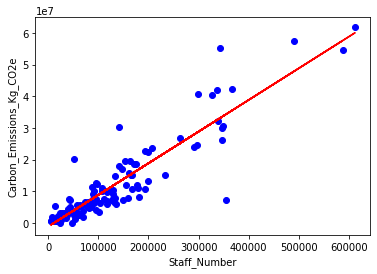

In [25]:
#Plot Outputs
plt.scatter(train.Staff_Number, train.Carbon_Emissions_Kg_CO2e, color='blue')
plt.plot(train_x2, regr2.coef_[0][0]*train_x2 + regr2.intercept_[0], '-r')
plt.xlabel("Staff_Number")
plt.ylabel("Carbon_Emissions_Kg_CO2e")

In [26]:
#Evaluation
test_x2 = np.asanyarray(test[['Staff_Number']])
test_y2 = np.asanyarray(test[["Carbon_Emissions_Kg_CO2e"]])
test_y_2 = regr2.predict(test_x2)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_2 - test_y2)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_2 - test_y2) ** 2))
print("R2-score: %.2f" % r2_score(test_y2 , test_y_2) )                         

Mean absolute error: 2868542.92
Residual sum of squares (MSE): 17667142595488.71
R2-score: 0.87


This test creates a much stronger correlation, showing that as staff numbers increase, so will carbon emmissions. The high R2-score indicates that we can be fairly confident in this metric.

#### test 3

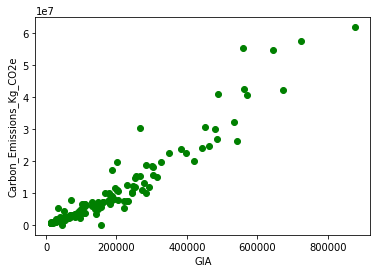

In [27]:
#Train Data distribution
plt.scatter(train.GIA, train.Carbon_Emissions_Kg_CO2e, color='Green')
plt.xlabel("GIA")
plt.ylabel("Carbon_Emissions_Kg_CO2e")
plt.show()

In [28]:
#Modelling Data
regr3 = linear_model.LinearRegression()
train_x3 = np.asanyarray(train[['GIA']])
train_y3 = np.asanyarray(train[["Carbon_Emissions_Kg_CO2e"]])
regr3.fit (train_x3, train_y3)
print ('Coefficients: ', regr3.coef_)
print ('Intercept: ',regr3.intercept_)

Coefficients:  [[70.81287324]]
Intercept:  [-2849643.40760457]


Text(0, 0.5, 'Carbon_Emissions_Kg_CO2e')

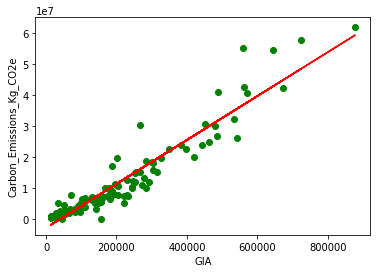

In [29]:
#Plot Outputs
plt.scatter(train.GIA, train.Carbon_Emissions_Kg_CO2e, color='Green')
plt.plot(train_x3, regr3.coef_[0][0]*train_x3 + regr3.intercept_[0], '-r')
plt.xlabel("GIA")
plt.ylabel("Carbon_Emissions_Kg_CO2e")

In [30]:
#Evaluation
test_x3 = np.asanyarray(test[['GIA']])
test_y3 = np.asanyarray(test[["Carbon_Emissions_Kg_CO2e"]])
test_y_3 = regr3.predict(test_x3)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_3 - test_y3)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_3 - test_y3) ** 2))
print("R2-score: %.2f" % r2_score(test_y3 , test_y_3) )                         

Mean absolute error: 2198102.08
Residual sum of squares (MSE): 8708113603334.03
R2-score: 0.94


Again, this creates a strong correlation between GIA and carbon emissions, with a similar R2 score.

#### test 4

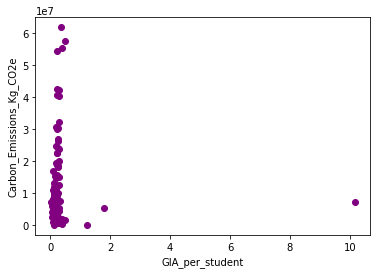

In [31]:
#Train Data distribution
plt.scatter(train.GIA_per_student, train.Carbon_Emissions_Kg_CO2e, color='purple')
plt.xlabel("GIA_per_student")
plt.ylabel("Carbon_Emissions_Kg_CO2e")
plt.show()

In [32]:
#Modelling Data
regr4 = linear_model.LinearRegression()
train_x4 = np.asanyarray(train[["GIA_per_student"]])
train_y4 = np.asanyarray(train[["Carbon_Emissions_Kg_CO2e"]])
regr4.fit (train_x4, train_y4)
print ('Coefficients: ', regr4.coef_)
print ('Intercept: ',regr4.intercept_)

Coefficients:  [[-31041.02511056]]
Intercept:  [11130699.36465891]


Text(0, 0.5, 'Carbon_Emissions_Kg_CO2e')

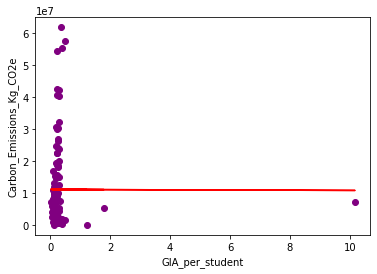

In [33]:
#Plot Outputs
plt.scatter(train.GIA_per_student, train.Carbon_Emissions_Kg_CO2e, color='purple')
plt.plot(train_x4, regr4.coef_[0][0]*train_x4 + regr4.intercept_[0], '-r')
plt.xlabel("GIA_per_student")
plt.ylabel("Carbon_Emissions_Kg_CO2e")

This does not give us a clear correlation, so we don't need to evaluate the strength of the relationship.

#### test 5

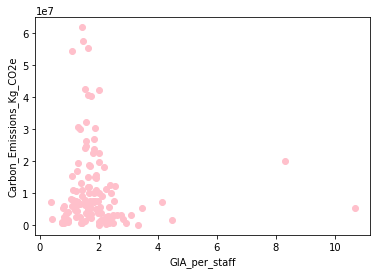

In [34]:
#Train Data distribution
plt.scatter(train.GIA_per_staff, train.Carbon_Emissions_Kg_CO2e, color='pink')
plt.xlabel("GIA_per_staff")
plt.ylabel("Carbon_Emissions_Kg_CO2e")
plt.show()

In [35]:
#Modelling Data
regr5 = linear_model.LinearRegression()
train_x5 = np.asanyarray(train[['GIA_per_staff']])
train_y5 = np.asanyarray(train[["Carbon_Emissions_Kg_CO2e"]])
regr5.fit (train_x5, train_y5)
print ('Coefficients: ', regr5.coef_)
print ('Intercept: ',regr5.intercept_)

Coefficients:  [[-680952.2988798]]
Intercept:  [12399400.61493557]


Text(0, 0.5, 'Carbon_Emissions_Kg_CO2e')

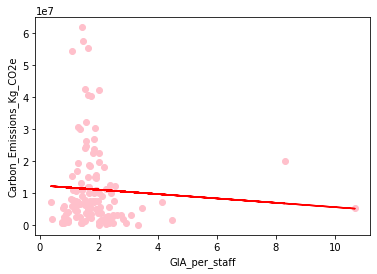

In [36]:
#Plot Outputs
plt.scatter(train.GIA_per_staff, train.Carbon_Emissions_Kg_CO2e, color='pink')
plt.plot(train_x5, regr5.coef_[0][0]*train_x5 + regr5.intercept_[0], '-r')
plt.xlabel("GIA_per_staff")
plt.ylabel("Carbon_Emissions_Kg_CO2e")

likewise, as there is no clear correlation, we will not evaluate the relationship

#### Multiple Linear Regression

based off our initial testing, we can see that the strongest variables are student number, staff number, and GIA, so we will factor these into a multiple linear regression test, to build a more informed model.

In [37]:
regrml = linear_model.LinearRegression()
x_ml = np.asanyarray(train[['Student_Number','Staff_Number','GIA']])
y_ml = np.asanyarray(train[["Carbon_Emissions_Kg_CO2e"]])
regrml.fit (x_ml, y_ml)
# The coefficients
print ('Coefficients: ', regrml.coef_)

Coefficients:  [[-2.55139895 57.37166229 43.01006604]]


In [38]:
y_hat_ml = regrml.predict(test[['Student_Number','Staff_Number','GIA']])
x_ml = np.asanyarray(test[['Student_Number','Staff_Number','GIA']])
y_ml = np.asanyarray(test[["Carbon_Emissions_Kg_CO2e"]])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat_ml - y_ml) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regrml.score(x_ml, y_ml))

Residual sum of squares: 9663377562523.23
Variance score: 0.93


from the vaiance score, we can see that the model will create a prediction with a high degree of accuracy.

## Section 3: Clustering the data, to create benchmark groups

#### Now that we have information on relationships between our variables, we will separate our data into clusters, to create benchmark groups for University carbon emmissions targerts

In [39]:
c_data_clustering = c_data.drop('Provider', 1)

In [40]:
X_cluster = c_data_clustering.values[:,1:]
X_cluster = np.nan_to_num(X_cluster)
cluster_dataset = StandardScaler().fit_transform(X_cluster)
cluster_dataset

array([[ 0.71454011, -0.02051444, -0.3508018 , ..., -0.59115822,
        -0.24473361, -0.65403616],
       [-0.89000277, -0.81356662, -0.89808621, ..., -1.19345158,
        -0.15920217, -0.25310288],
       [-0.55695694, -0.57684953, -0.70230265, ..., -0.80961833,
        -0.1842304 , -0.43034364],
       ...,
       [-0.56268126, -0.81789478, -0.94445285, ..., -0.40355624,
        -0.2748151 , -0.54603445],
       [-0.93683239, -0.86450574, -0.90183242, ..., -1.38674154,
        -0.12425364,  0.22484638],
       [-0.73886794, -0.80574264, -0.76780335, ...,  0.03479819,
        -0.15307248,  0.54985215]])

In [41]:
num_clusters = 10

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 5 5 5 0 0 0 5 0 1 0 5 1 1 9 0 7 5 5 2 0 5 1 5 4 4 1 5 0 0 1 1 0 5 1 0 9
 2 5 9 5 5 0 9 1 5 1 5 5 4 2 6 5 1 1 1 2 0 5 0 0 1 1 0 0 5 2 0 1 2 2 1 0 1
 0 2 1 0 1 6 5 5 1 5 5 9 9 1 1 5 5 9 8 7 0 0 5 5 5 5 5 9 7 1 2 7 0 7 0 1 1
 2 2 1 3 7 2 9 1 0 9 9 9 0 9 5 2 5 5 1 5 5 4 5 5 9 5 1 9 1 1 9 4 1 4 4 4 4
 5 4 4 5 4 4]


In [42]:
c_data["Labels"] = pd.Categorical(labels)
c_data.head(5)

<ipython-input-42-306cc1d4bb4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data["Labels"] = pd.Categorical(labels)


,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Labels
0,10000291.0,Anglia Ruskin University,1763180,118000,129750.17,6005516.418,0.474311,51.741266,0.073589,1.099578,0
1,10000385.0,The Arts University Bournemouth,243940,22720,35090.95,1133069.664,-1.897700,50.741781,0.143851,1.544496,5
2,10000571.0,Bath Spa University,559280,51160,68954.00,2486984.472,-2.437400,51.378739,0.123291,1.347811,5
3,10000712.0,University College Birmingham,353240,27060,67293.81,3102714.214,-1.905934,52.481855,0.190505,2.486837,5
4,10000824.0,Bournemouth University,1287320,75420,91393.00,3581959.766,-1.897159,50.742968,0.070995,1.211787,0


we need the mean carbon emission from each group for our results later

In [43]:
mean = c_data.groupby(['Labels']).mean()
mean

,UKPRN,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff
Labels,,,,,,,,,
0,1.000522e+07,1.263389e+06,120350.000000,181896.980643,8.884041e+06,-0.155266,51.516155,0.149069,1.557712
1,1.000639e+07,1.483076e+06,132556.969697,202608.475515,9.587462e+06,-2.121972,52.940745,0.144011,1.550950
2,1.000697e+07,2.061674e+06,305200.000000,498030.494231,3.125982e+07,-2.267058,53.193451,0.244969,1.654804
3,1.000780e+07,1.760000e+04,43100.000000,179130.000000,7.234093e+06,-0.127819,51.520998,10.177841,4.156148
4,1.001207e+07,4.195554e+05,35260.000000,96787.048231,3.403768e+06,-3.887276,52.685218,0.224235,2.695819
5,1.000621e+07,3.152898e+05,33453.658537,49879.772390,2.265754e+06,-0.616725,51.831387,0.253314,1.596784
6,1.000714e+07,1.043860e+06,31880.000000,280345.955000,1.277720e+07,-2.642174,55.709056,0.252736,9.491069
7,1.000703e+07,2.173200e+06,531853.333333,722043.354833,5.481265e+07,-1.146526,52.734031,0.352838,1.389405
8,1.000777e+07,8.809775e+06,355440.000000,131297.000000,7.127026e+06,-0.709726,52.024924,0.014904,0.369393


Now that we have the clusters, we'll visualise these on our map to see how well they are spread out.

In [44]:
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x_clusters = np.arange(num_clusters)
ys = [i+x_clusters+(i*x_clusters)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(c_data['Latitude'], c_data['Longitude'], c_data['Provider'],k_means.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
cluster_map

### Section 4: Mapping the results, to analyse any regional disparity

#### Now that we have information on the relationships between our variables, and benchmark clusters, we will map these to assess if there are any visual regional changes in carbon emmissions, or any of our independent variables.


In [45]:
c_data

,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Labels
0,10000291.0,Anglia Ruskin University,1763180,118000,129750.17,6005516.418,0.474311,51.741266,0.073589,1.099578,0
1,10000385.0,The Arts University Bournemouth,243940,22720,35090.95,1133069.664,-1.897700,50.741781,0.143851,1.544496,5
2,10000571.0,Bath Spa University,559280,51160,68954.00,2486984.472,-2.437400,51.378739,0.123291,1.347811,5
3,10000712.0,University College Birmingham,353240,27060,67293.81,3102714.214,-1.905934,52.481855,0.190505,2.486837,5
4,10000824.0,Bournemouth University,1287320,75420,91393.00,3581959.766,-1.897159,50.742968,0.070995,1.211787,0
...,...,...,...,...,...,...,...,...,...,...,...
150,10008026.0,St Mary's University College,75260,6240,14585.00,490116.680,-5.961300,54.592000,0.193795,2.337340,4
151,10008640.0,Falmouth University,462420,24120,74766.92,2993218.522,-5.070901,50.149168,0.161686,3.099789,4
152,10014001.0,University of Suffolk,553860,22200,27071.30,1164296.062,1.162554,52.052585,0.048878,1.219428,5
153,10037449.0,University of St Mark and St John,199600,16600,34443.00,1689156.066,-4.110286,50.421023,0.172560,2.074880,4


In [46]:
m = folium.Map(location=[latitude, longitude], zoom_start=5)

for i in range(0,len(c_data)):
   folium.Circle(
      location=[c_data.iloc[i]['Latitude'], c_data.iloc[i]['Longitude']],
      popup=c_data.iloc[i]['Provider'],
      radius=c_data.iloc[i]['Carbon_Emissions_Kg_CO2e']/1250,
      color='Orange',
      fill=True,
      fill_color='orange'
   ).add_to(m)
 
    
m

In [47]:
m2 = folium.Map(location=[latitude, longitude], zoom_start=5)

for i in range(0,len(c_data)):
   folium.Circle(
      location=[c_data.iloc[i]['Latitude'], c_data.iloc[i]['Longitude']],
      popup=c_data.iloc[i]['Provider'],
      radius=c_data.iloc[i]['GIA']/19,
      color='Green',
      fill=True,
      fill_color='Green'
   ).add_to(m2)
 
    
m2

In [48]:
m3 = folium.Map(location=[latitude, longitude], zoom_start=5)

for i in range(0,len(c_data)):
   folium.Circle(
      location=[c_data.iloc[i]['Latitude'], c_data.iloc[i]['Longitude']],
      popup=c_data.iloc[i]['Provider'],
      radius=c_data.iloc[i]['Student_Number']/100,
      color='Grey',
      fill=True,
      fill_color='Grey'
   ).add_to(m3)
 
    
m3

In [49]:
m4 = folium.Map(location=[latitude, longitude], zoom_start=5)

for i in range(0,len(c_data)):
   folium.Circle(
      location=[c_data.iloc[i]['Latitude'], c_data.iloc[i]['Longitude']],
      popup=c_data.iloc[i]['Provider'],
      radius=c_data.iloc[i]['Staff_Number']/13,
      color='Blue',
      fill=True,
      fill_color='Blue'
   ).add_to(m4)
 
    
m4

From our maps, we can draw the following conclusions:
   - Universities with the highest carbon emissions, student numbers, staff numbers and GIA are situated in metroplitan areas.
   - by contrast, these variables are lower for universities in rural areas.
   - coastal areas also record lower carbon emissions.
   

## Section 5: Assessing whether Urbanisation affects carbon emmissions

#### Using the foursquare API, we will create an urbanisation metric analysing how built up an area is, based on the amount of venues within its proximity. A regression test will then be conducted to review the effect of this on carbon emmissions

To create this metric, we first want to record how many venues are nearby to the University

In [50]:
#Foursquare credentials

CLIENT_ID = 'Foursquare ID' 
CLIENT_SECRET = 'Foursquare Secret' 
VERSION = '20180604'
radius = 250

In [51]:
#Defining the global url and reviewing request
url = 'https://api.foursquare.com/v2/venues/get?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius)
    
requests.get(url).json()

{'meta': {'code': 400,
  'errorType': 'param_error',
  'errorDetail': 'Value get is invalid for venue id',
  'requestId': '5fc9e27c3239aa3c67410f58'},
 'response': {}}

In [52]:
#Creating a function to explore nearby venues
def getNearbyVenues(names, latitudes, longitudes):
    venues_list =[]
    radius = 250
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Provider', 
                  'Provider Latitude', 
                  'Provider Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [55]:
#running the function
Nearby_venues = getNearbyVenues(names = c_data['Provider'],
                                   latitudes = c_data['Latitude'],
                                   longitudes = c_data['Longitude']
                                  )

Anglia Ruskin University
The Arts University Bournemouth
Bath Spa University
University College Birmingham
Bournemouth University
The University of Brighton
Brunel University London
Buckinghamshire New University
Canterbury Christ Church University
University of Northumbria at Newcastle
City, University of London
Conservatoire for Dance and Drama
Coventry University
De Montfort University
Glasgow School of Art
Goldsmiths College
Imperial College of Science, Technology and Medicine
The Institute of Cancer Research
The University of Winchester
King's College London
Kingston University
Leeds Arts University
Leeds Beckett University
Leeds Trinity University
The Liverpool Institute for Performing Arts
Liverpool Hope University
Liverpool John Moores University
London Metropolitan University
London School of Economics and Political Science
London South Bank University
Loughborough University
The Manchester Metropolitan University
Middlesex University
Norwich University of the Arts
The Notting

In [56]:
Nearby_venues

,Provider,Provider Latitude,Provider Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anglia Ruskin University,51.741266,0.474311,Best Western Atlantic Hotel,51.739884,0.474678,Hotel
1,Anglia Ruskin University,51.741266,0.474311,Subway,51.741121,0.473110,Sandwich Place
2,Anglia Ruskin University,51.741266,0.474311,Papa John’s,51.741358,0.473090,Pizza Place
3,Anglia Ruskin University,51.741266,0.474311,Spar,51.740872,0.473404,Convenience Store
4,Anglia Ruskin University,51.741266,0.474311,Wok Inn,51.741198,0.473268,Chinese Restaurant
...,...,...,...,...,...,...,...
1652,University of St Mark and St John,50.421023,-4.110286,Barjon,50.420970,-4.110054,Bar
1653,University of St Mark and St John,50.421023,-4.110286,UCP Marjon Sports Centre,50.419776,-4.113116,College Gym
1654,Harper Adams University,52.780019,-2.425380,lamb inn,52.779259,-2.427343,Pub
1655,Harper Adams University,52.780019,-2.425380,Shropshire Potato Day,52.779907,-2.425495,Farmers Market


<function matplotlib.pyplot.show(close=None, block=None)>

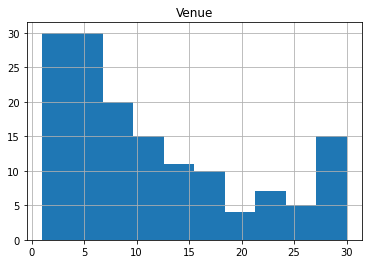

In [57]:
g_venues = Nearby_venues.groupby(by='Provider').count()
g_venues[['Venue']].hist()
plt.show

In [58]:
venues_sorted = Nearby_venues[['Provider', 'Venue']].groupby(by='Provider').count()
Provider_um = venues_sorted.rename(columns={'Venue' : 'Urbanisation_metric'})
Provider_um

,Urbanisation_metric
Provider,
Aberystwyth University,1
Anglia Ruskin University,6
Aston University,4
Bangor University,5
Birkbeck College,26
...,...
"University of the Arts, London",30
University of the Highlands and Islands,4
"University of the West of England, Bristol",5


Now we want to add the urbanisation metric to our overall dataset

In [59]:
Total_data = pd.merge(c_data, Provider_um, on ="Provider")
Total_data

,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Labels,Urbanisation_metric
0,10000291.0,Anglia Ruskin University,1763180,118000,129750.170,6.005516e+06,0.474311,51.741266,0.073589,1.099578,0,6
1,10000385.0,The Arts University Bournemouth,243940,22720,35090.950,1.133070e+06,-1.897700,50.741781,0.143851,1.544496,5,4
2,10000712.0,University College Birmingham,353240,27060,67293.810,3.102714e+06,-1.905934,52.481855,0.190505,2.486837,5,15
3,10000824.0,Bournemouth University,1287320,75420,91393.000,3.581960e+06,-1.897159,50.742968,0.070995,1.211787,0,4
4,10000961.0,Brunel University London,1064800,97040,246280.819,1.215999e+07,-0.472835,51.532849,0.231293,2.537931,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
142,10008017.0,Trinity Laban Conservatoire of Music and Dance,85780,24600,18836.600,9.893457e+05,-0.007171,51.483596,0.219592,0.765715,5,23
143,10008026.0,St Mary's University College,75260,6240,14585.000,4.901167e+05,-5.961300,54.592000,0.193795,2.337340,4,5
144,10014001.0,University of Suffolk,553860,22200,27071.300,1.164296e+06,1.162554,52.052585,0.048878,1.219428,5,14
145,10037449.0,University of St Mark and St John,199600,16600,34443.000,1.689156e+06,-4.110286,50.421023,0.172560,2.074880,4,2


#### testing the urbanisation metric

As with our other dependent variables, we will test the urbanisation metric, to analyse its effect on carbon emissions.

In [60]:
#Split into train and test
msk_um = np.random.rand(len(Total_data)) < 0.8
train_um = Total_data[msk_um]
test_um = Total_data[~msk_um]

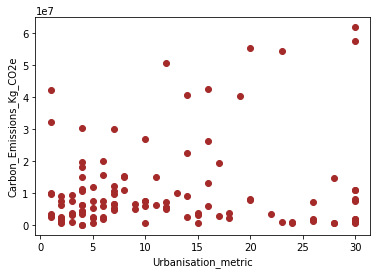

In [61]:
#Train Data distribution
plt.scatter(train_um.Urbanisation_metric, train_um.Carbon_Emissions_Kg_CO2e, color='Brown')
plt.xlabel("Urbanisation_metric")
plt.ylabel("Carbon_Emissions_Kg_CO2e")
plt.show()

In [62]:
#Modelling Data
regr_um = linear_model.LinearRegression()
train_x_um = np.asanyarray(train_um[['Urbanisation_metric']])
train_y_um = np.asanyarray(train_um[["Carbon_Emissions_Kg_CO2e"]])
regr_um.fit (train_x_um, train_y_um)
print ('Coefficients: ', regr_um.coef_)
print ('Intercept: ',regr_um.intercept_)

Coefficients:  [[196125.36774315]]
Intercept:  [8335334.33626044]


Text(0, 0.5, 'Carbon_Emissions_Kg_CO2e')

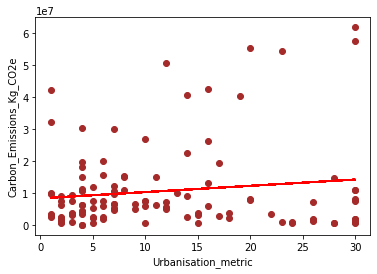

In [63]:
#Plot Outputs
plt.scatter(train_um.Urbanisation_metric, train_um.Carbon_Emissions_Kg_CO2e, color='Brown')
plt.plot(train_x_um, regr_um.coef_[0][0]*train_x_um + regr_um.intercept_[0], '-r')
plt.xlabel("Urbanisation_metric")
plt.ylabel("Carbon_Emissions_Kg_CO2e")

In [64]:
#Evaluation
test_x_um = np.asanyarray(test_um[["Carbon_Emissions_Kg_CO2e"]])
test_y_um = np.asanyarray(test_um[["Urbanisation_metric"]])
test_y_um2 = regr_um.predict(test_x_um)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_um2 - test_y_um)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_um2 - test_y_um) ** 2))
print("R2-score: %.2f" % r2_score(test_y_um , test_y_um2) )                         

Mean absolute error: 2096630439023.40
Residual sum of squares (MSE): 8619123782903030425321472.00
R2-score: -147399686005086169858048.00


The metric is not that useful, showing no clear correlation, and when evaluated, not showing a strong result. We will however factor it into our multiple linear regression model, in order to:
   -  assess its impact on the strength of the model
   -  create a more informed model

#### Multiple Linear Regression

In [65]:
um_x = np.asanyarray(train_um[['Student_Number','Staff_Number','GIA', 'Urbanisation_metric']])
um_y = np.asanyarray(train_um[["Carbon_Emissions_Kg_CO2e"]])
regr_um.fit (um_x, um_y)
# The coefficients
print ('Coefficients: ', regr_um.coef_)

Coefficients:  [[-4.04526005e+00  5.01155944e+01  5.16494325e+01  1.35817385e+04]]


In [66]:
um_y_hat= regr_um.predict(test_um[['Student_Number','Staff_Number','GIA', 'Urbanisation_metric']])
um_x = np.asanyarray(test_um[['Student_Number','Staff_Number','GIA', 'Urbanisation_metric']])
um_y = np.asanyarray(test_um[["Carbon_Emissions_Kg_CO2e"]])
print("Residual sum of squares: %.2f"
      % np.mean((um_y_hat - um_y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr_um.score(um_x, um_y))

Residual sum of squares: 17374499619399.03
Variance score: 0.84


This doesn't provide a better variance score than our earlier model, but the urbanisation metric doesn't lower it to much, and overall it is still a strong model, so we will use this one, as it is more informed

In [67]:
model=regr_um.fit(um_x,um_y)

## Section 6: Using the model to predict carbon emmisions targets for a new University

#### Now that we have assessed our data, we can conclude that:
   - We are best predicting carbon emmissions through our second multiple linear regression model.
   - There are 10 benchmark clusters in our data which our prediction could fall into.
   - The identified regional variables have to be accounted for.
   - Urbanisation does not have a tangible effect on carbon emmisions data, based on our metric.

#### Testing the model

We want to conduct a quick test on our model, to check that it can produce the desired outcome.

In [68]:
Total_data.sample()

,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Labels,Urbanisation_metric
19,10003854.0,Leeds Arts University,133080,11980,23472.0,739259.227,-1.55178,53.808463,0.176375,1.959265,5,15


In [69]:
d = {'Student_Number': [133080], 'Staff_Number': [11980], 'GIA' : [23472], 'Urbanisation_Metric' : 15}
df = pd.DataFrame(data=d)
print(df)

   Student_Number  Staff_Number    GIA  Urbanisation_Metric
0          133080         11980  23472                   15


In [70]:
y_pred=model.predict(df)
print(y_pred)

[[499601.02349844]]


#### Use Study 1 - Poppleton University

Our first case study is a medium sized university, situated in Leeds city centre, with a relatively large campus.

In [88]:
# Background and University specific data
Uni1PD = {'Student_Number': [125000], 'Staff_Number': [125000], 'GIA' : [150000], 'Urbanisation_metric' : [30]}
Uni_1 = pd.DataFrame(data=Uni1PD)
print(Uni_1)

   Student_Number  Staff_Number     GIA  Urbanisation_metric
0          125000        125000  150000                   30


We will now use the model to predict our estimated carbon emissions output.

In [89]:
# Using the model
y_pred_1=model.predict(Uni_1)
print(y_pred_1)

[[10413210.43849994]]


We want to provide the university with a ranged target for carbon emissions, so based on , we will assign a cluster, and use the minimum and maximum boundaries as a range.

In [90]:
# Assigning a cluster
predicted = {'Student_Number': [50000], 'Staff_Number': [5000], 'GIA' : [300000], 'Urbanisation_metric' : 30,  'Carbon_Emissions_Kg_CO2e' : y_pred_1}
p_appended = mean.append(predicted, ignore_index=True)
p_appended['Carbon_Emissions_Kg_CO2e'] = p_appended['Carbon_Emissions_Kg_CO2e'].astype('int64')
p_appended

,UKPRN,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Urbanisation_metric
0,1.000522e+07,1.26339e+06,120350,181897,8884041,-0.155266,51.516155,0.149069,1.557712,NaN
1,1.000639e+07,1.48308e+06,132557,202608,9587462,-2.121972,52.940745,0.144011,1.550950,NaN
2,1.000697e+07,2.06167e+06,305200,498030,31259817,-2.267058,53.193451,0.244969,1.654804,NaN
3,1.000780e+07,17600,43100,179130,7234093,-0.127819,51.520998,10.177841,4.156148,NaN
4,1.001207e+07,419555,35260,96787,3403768,-3.887276,52.685218,0.224235,2.695819,NaN
5,1.000621e+07,315290,33453.7,49879.8,2265753,-0.616725,51.831387,0.253314,1.596784,NaN
6,1.000714e+07,1.04386e+06,31880,280346,12777200,-2.642174,55.709056,0.252736,9.491069,NaN
7,1.000703e+07,2.1732e+06,531853,722043,54812650,-1.146526,52.734031,0.352838,1.389405,NaN
8,1.000777e+07,8.80978e+06,355440,131297,7127026,-0.709726,52.024924,0.014904,0.369393,NaN
9,1.000705e+07,867940,84773.8,160328,9338741,-3.534701,56.053455,0.254138,2.027421,NaN


Based on the table, cluster 1 provides the closest GIA, so we'll use that one.

In [93]:
#create table of just that cluster
Cluster_table1 = Total_data['Labels']==1

In [94]:
cdf1 = pd.DataFrame(Total_data[Cluster_table1])
cdf1

,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Labels,Urbanisation_metric
7,10001282.0,University of Northumbria at Newcastle,1904300,128840,242948.000,1.044221e+07,-1.607512,54.976769,0.127579,1.885657,1,6
10,10001726.0,Coventry University,2518740,199420,277215.860,1.310237e+07,-1.505713,52.408016,0.110061,1.390111,1,16
11,10001883.0,De Montfort University,1857160,131160,180264.130,6.537805e+06,-1.139356,52.631833,0.097064,1.374383,1,7
20,10003861.0,Leeds Beckett University,1675940,129320,233337.850,7.572848e+06,-1.549143,53.803662,0.139228,1.804345,1,10
24,10003957.0,Liverpool John Moores University,1730180,117780,148881.150,7.071032e+06,-2.973176,53.403702,0.086050,1.264061,1,26
28,10004113.0,Loughborough University,1297760,162480,326751.360,1.967446e+07,-1.229467,52.764892,0.251781,2.011025,1,4
29,10004180.0,The Manchester Metropolitan University,2379560,192480,272865.800,1.080362e+07,-2.239504,53.470699,0.114671,1.417632,1,30
32,10004797.0,The Nottingham Trent University,2394340,178320,201310.490,1.092254e+07,-1.152002,52.956383,0.084078,1.128928,1,30
41,10005790.0,Sheffield Hallam University,2211480,180440,192323.950,8.049063e+06,-1.465255,53.379212,0.086966,1.065861,1,30
43,10006299.0,Staffordshire University,1069460,80760,97551.000,4.788175e+06,-2.182605,53.010097,0.091215,1.207912,1,7


In [95]:
#View min/max of that cluster to get a target range
cdf1max = (cdf1.Carbon_Emissions_Kg_CO2e.max()) 
cdf1min = (cdf1.Carbon_Emissions_Kg_CO2e.min()) 
print(cdf1max)
print(cdf1min)

19674461.337
3229459.5110000004


We want to see where these universities in our cluster are, so that we can compare with the regional concerns of our target university

In [96]:
clustermap1 = folium.Map(location=[latitude, longitude], zoom_start=5)

for i in range(0,len(cdf1)):
   folium.Circle(
      location=[cdf1.iloc[i]['Latitude'], cdf1.iloc[i]['Longitude']],
      popup=cdf1.iloc[i]['Provider'],
      radius=cdf1.iloc[i]['Carbon_Emissions_Kg_CO2e']/300,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(clustermap1)
 
    
clustermap1

Based on our results we draw the following conclusions:
 - The model predicts that the University would produce 10413210.43849994 Kg/CO2e Carbon Emissions 
 - This falls within cluster 2 of our groups - which ranges from 5229459.5110000004 to 19674461.337
 - These Universities generally are within metropolitan non-coastal areas, which is representative of our chosen case study.

As a result, we make the following recommendation:
 - The predicted carbon output is in the middle of the range to aim for, and based on the likeliness to other Universities in the cluster, is a realistic target. The University should aim to record this amount of scope 1 and 2 carbon emissions at a maximum, and aim lower where possible. 

#### Use Study 2 - The University of Life

We will now do the same for our second case study

Our second case study is a smaller specialist university, with a small campus in Cornwall.

In [97]:
# Background and University specific data
Uni2PD = {'Student_Number': [50000], 'Staff_Number': [7500], 'GIA' : [30000], 'Urbanisation_metric' : [1]}
Uni_2 = pd.DataFrame(data=Uni2PD)
print(Uni_2)

   Student_Number  Staff_Number    GIA  Urbanisation_metric
0           50000          7500  30000                    1


In [98]:
# Using the model
y_pred_2=model.predict(Uni_2)
print(y_pred_2)

[[595366.28194308]]


In [99]:
# Assigning a cluster
predicted = {'Student_Number': [50000], 'Staff_Number': [7500], 'GIA' : [30000], 'Urbanisation_metric' : [1],  'Carbon_Emissions_Kg_CO2e' : y_pred_2}
p_appended2 = mean.append(predicted, ignore_index=True)
p_appended2['Carbon_Emissions_Kg_CO2e'] = p_appended2['Carbon_Emissions_Kg_CO2e'].astype('int64')
p_appended2

,UKPRN,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Urbanisation_metric
0,1.000522e+07,1.26339e+06,120350,181897,8884041,-0.155266,51.516155,0.149069,1.557712,NaN
1,1.000639e+07,1.48308e+06,132557,202608,9587462,-2.121972,52.940745,0.144011,1.550950,NaN
2,1.000697e+07,2.06167e+06,305200,498030,31259817,-2.267058,53.193451,0.244969,1.654804,NaN
3,1.000780e+07,17600,43100,179130,7234093,-0.127819,51.520998,10.177841,4.156148,NaN
4,1.001207e+07,419555,35260,96787,3403768,-3.887276,52.685218,0.224235,2.695819,NaN
5,1.000621e+07,315290,33453.7,49879.8,2265753,-0.616725,51.831387,0.253314,1.596784,NaN
6,1.000714e+07,1.04386e+06,31880,280346,12777200,-2.642174,55.709056,0.252736,9.491069,NaN
7,1.000703e+07,2.1732e+06,531853,722043,54812650,-1.146526,52.734031,0.352838,1.389405,NaN
8,1.000777e+07,8.80978e+06,355440,131297,7127026,-0.709726,52.024924,0.014904,0.369393,NaN
9,1.000705e+07,867940,84773.8,160328,9338741,-3.534701,56.053455,0.254138,2.027421,NaN


Based on the table, cluster 5 provides the closest mean Carbon_Emissions_Kg_CO2e, so we'll use that one.

In [100]:
#create table of just that cluster
Cluster_table2 = Total_data['Labels']==5

In [101]:
cdf2 = pd.DataFrame(Total_data[Cluster_table2])
cdf2

,UKPRN,Provider,Student_Number,Staff_Number,GIA,Carbon_Emissions_Kg_CO2e,Longitude,Latitude,GIA_per_student,GIA_per_staff,Labels,Urbanisation_metric
1,10000385.0,The Arts University Bournemouth,243940,22720,35090.950,1.133070e+06,-1.897700,50.741781,0.143851,1.544496,5,4
2,10000712.0,University College Birmingham,353240,27060,67293.810,3.102714e+06,-1.905934,52.481855,0.190505,2.486837,5,15
5,10000975.0,Buckinghamshire New University,792180,28400,65873.390,2.681620e+06,-0.752021,51.627518,0.083155,2.319486,5,17
9,10001653.0,Conservatoire for Dance and Drama,108580,25140,53279.000,1.574784e+06,-0.129090,51.526207,0.490689,2.119292,5,26
15,10003324.0,The Institute of Cancer Research,18840,43500,33773.460,5.178025e+06,-0.181668,51.490713,1.792646,0.776401,5,7
16,10003614.0,The University of Winchester,559260,49680,71007.000,2.336587e+06,-1.326928,51.060033,0.126966,1.429287,5,5
19,10003854.0,Leeds Arts University,133080,11980,23472.000,7.392592e+05,-1.551780,53.808463,0.176375,1.959265,5,15
21,10003863.0,Leeds Trinity University,245840,19160,43503.890,1.724492e+06,-1.648100,53.848573,0.176960,2.270558,5,2
25,10004048.0,London Metropolitan University,662280,44860,92984.270,3.817968e+06,-0.110210,51.551822,0.140400,2.072766,5,18
31,10004775.0,Norwich University of the Arts,166000,14560,20328.000,7.459902e+05,1.296600,52.630313,0.122458,1.396154,5,30


In [102]:
#View min/max of that cluster to get a target range
cdf2max = (cdf2.Carbon_Emissions_Kg_CO2e.max()) 
cdf2min = (cdf2.Carbon_Emissions_Kg_CO2e.min()) 
print(cdf2max)
print(cdf2min)

10709009.442
456340.662


In [103]:
clustermap2 = folium.Map(location=[latitude, longitude], zoom_start=5)

for i in range(0,len(cdf2)):
   folium.Circle(
      location=[cdf2.iloc[i]['Latitude'], cdf2.iloc[i]['Longitude']],
      popup=cdf2.iloc[i]['Provider'],
      radius=cdf2.iloc[i]['Carbon_Emissions_Kg_CO2e']/300,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(clustermap2)
 
    
clustermap2

Based on our results we draw the following conclusions:
 - The model predicts that the University would produce 595366.28194308 Kg/CO2e Carbon Emissions 
 - This falls within cluster 5 of our groups - which ranges from 456340.662 to 7656865.655
 - These Universities are generally more rural areas some of which are coastal.

As a result, we make the following recommendation:
 - The predicted carbon output is at the lower end of the range to aim for, and based on the likeliness to other Universities in the cluster, and the case studies position as a rural, coastal campus, this is a realistic target. The University should aim to record this amount of scope 1 and 2 carbon emissions at a maximum, and aim lower where possible. 